In [1]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs 

In [2]:
zoom = 5
nside = 2**zoom
Np = hp.nside2npix(nside)
print('effective res is ~' + str(1/np.sqrt(Np/360/180)) + ' degrees')

effective res is ~2.296396633859229 degrees


In [3]:
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + str(zoom) + '.zarr/' 
#file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT1H.z' + str(zoom) + '.zarr'
ds2d = xr.open_zarr(file)
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z' + str(zoom) + '.zarr/' 
#file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + str(zoom) + '.zarr'
ds3d = xr.open_zarr(file)

In [4]:
#...variables used for IDing
psl = ds2d['psl']
Nt,Np = np.shape(psl)
psl = psl[np.arange(Nt,step=3),:]
zgp = ds3d['zg']
Nt,Np = np.shape(psl)
z3m5 = zgp[:,11,:] - zgp[:,13,:]
was = ds3d['wa'][:,11,:]

In [5]:
p0 = np.asarray(psl[:,:])
zd = np.asarray(z3m5[:,:])
wa = np.asarray(was[:,:])
Nt,Np = np.shape(p0)

In [6]:
#...find all local psl minima (first pass)
step = 1024
icy = np.zeros((Nt,Np))
for n in np.arange(Np,step=step):
 ip  = np.arange(step)+n
 ips = np.ravel(hp.get_all_neighbours(nside,ip,nest=True).T)
 ip0 = np.repeat(ip,8)
 icy[:,ip] = np.min(np.reshape(p0[:,ips]-p0[:,ip0],shape=(Nt,step,8)),axis=2)>1

In [7]:
#...apply msl criteria and whatever other filters (second pass)
psl_rad = 5.5
zgp_rad = 6.5
for ip in np.arange(Np):
 its = np.nonzero(icy[:,ip])[0]
 if(len(its)):
  vec = hp.pix2vec(nside,ipix=ip,nest=True)
  ipsp = hp.query_disc(nside, vec, radius=np.radians(psl_rad),nest=True)
  #...this code is to define a ring of points, rather than a disc
  #ipsz = np.setdiff1d(hp.query_disc(nside, vec, radius=np.radians(zgp_rad  ),nest=True),
  #                    hp.query_disc(nside, vec, radius=np.radians(zgp_rad/2),nest=True))
  for it in its:
   icy[it,ip] = icy[it,ip] * ((np.max(p0[it,ipsp])-p0[it,ip])>200) * (np.max(wa[it,ipsp])>0.15)
   # * ((zd[it,ip]-np.mean(zd[it,ipsz]))>6)

In [8]:
#...tracking, step 1
#   for each cyclone, just find the next, if there is one close enough
rad_max = 5
icy_next = np.zeros((Nt,Np))-1
ips0 = np.nonzero(icy[0,:])[0]
for it in np.arange(Nt-1):
 ips1 = np.nonzero(icy[it+1,:])[0]
 for ip0 in ips0:
  #...first check for immediate neighbours
  ips = hp.get_all_neighbours(nside,ip0,nest=True)
  ip1 = np.intersect1d(ips,ips1)
  if(len(ip1)>0):
   icy_next[it,ip0] = ip1[0]    #...if more than one, arbitrarily pick the first (zeroth - eye roll)
  else:
   #...otherwise use an increasing search radius
   rad = 1
   vec = hp.pix2vec(nside,ipix=ip0)
   while(rad<=rad_max):   
    ips = hp.query_disc(nside, vec, radius=np.radians(rad))
    ip1 = np.intersect1d(ips,ips1)
    rad = rad+1
    if(len(ip1)>0):
     icy_next[it,ip0] = ip1[0]
 ips0 = ips1

In [49]:
a=(np.reshape(np.arange(6),(3,2)))
a

array([[0, 1],
       [2, 3],
       [4, 5]])

In [121]:
tk = np.ravel(tracks.T)
a = np.diff(np.asarray(-1==tk,dtype=float))
i0 = np.nonzero(a<0)[0]+1
i1 = np.nonzero(a>0)[0]+1
ii = np.ravel(np.reshape(np.concatenate((i0,i1)),shape=(2,len(i0))).T)
tk2 = np.split(tk,ii)


In [144]:
#tk2 = tk2[np.arange(1,len(tk2),step=2)]
tk2[np.arange(10)]
tk2[0:10]


TypeError: only integer scalar arrays can be converted to a scalar index

In [15]:
#...tracking, step 2
#   join them up
tracks = np.array(icy_next,dtype=int)
for it in np.arange(Nt-1,0,step=-1):
 ips = np.nonzero(tracks[it,:]>=0)[0]
 if(len(ips)):
  for ip in ips:
   tracks[np.arange(it+1,Nt),ip] = tracks[np.arange(it+1,Nt),tracks[it,ip]] 
tk = np.ravel(tracks.T)
a = np.diff(np.asarray(-1==tk,dtype=float))
i0 = np.nonzero(a<0)[0]+1
i1 = np.nonzero(a>0)[0]+1
ii = np.ravel(np.reshape(np.concatenate((i0,i1)),shape=(2,len(i0))).T)
tk2 = np.split(tk,ii)

<Figure size 640x480 with 0 Axes>

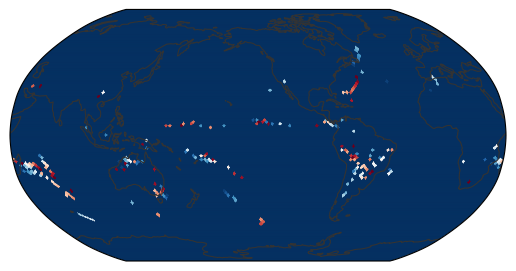

In [29]:
m = psl[0,:]*0
for n in np.arange(30):
 m[icy[n,:]==1]=n+1
#m = (np.sum(icy,axis=0))
egh.healpix_show(m, cmap = 'RdBu_r',vmax=30)
#hp.mollview(m, title=str(n),nest=True)

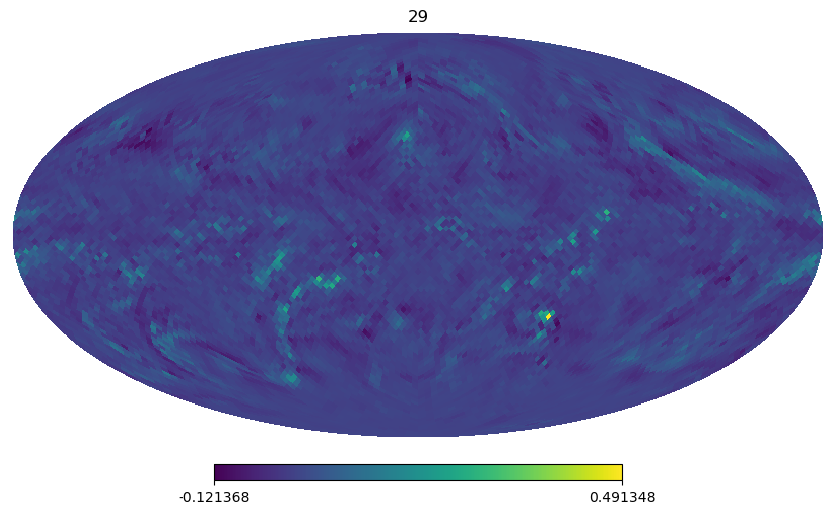

In [13]:
m = wa[10,:]
hp.mollview(m, title=str(n),nest=True)

In [18]:
#(a) msl,200.0,5.5,0 represents that mean sea level pressure must increase by 200 Pa 
#over a 5.5 great circle distance (GCD) from the detected node;
#(b) _DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0 represents that the difference between geopotential (Z)
#on the 300 and 500 millibars surfaces must decrease by 58.8 m2 s−2 over a 6.5
#GCD, using the maximum value of this field within 1 GCD as reference. This ensures a coherent upper-level warm
#core attached to the detected surface low
psl_rad = 5.5
zgp_rad = 6.5
Nt,Np = np.shape(psl)
iok = np.zeros((Nt,Np))
for ip in np.arange(1):
 vec = hp.pix2vec(nside,ipix=ip)
 #...surface pressure criteria
 ips = hp.query_disc(nside, vec, radius=np.radians(psl_rad))
 iok[:,ip] = np.max(psl[:,ips]-psl[:,ip],axis=1)>200
# #...upper warm core criteria
# ips = hp.query_disc(nside, vec, radius=np.radians(zgp_rad))
# ii[:,ip] = ii & (np.max(z3m5[:,ips]-z3m5[:,ip],axis=1)>58.8)

In [143]:
np.sum(

np.int64(191)

In [115]:
a=hp.pix2vec(nside,ipix=ipin)
hp.vec2pix(nside,0.14,0.14,0.97)

np.int64(0)

In [118]:
hp.pix2vec(nside,ipix=1)

(np.float64(-0.14358384116760659),
 np.float64(0.1435838411676066),
 np.float64(0.9791666666666666))

In [119]:
hp.vec2pix(nside,-0.14,0.14,0.98)

np.int64(1)

In [101]:
hp.vec2pix(nside,a[0,1],a[1,1],a[2,1])

TypeError: tuple indices must be integers or slices, not tuple

In [27]:
#...group the same event
for ip in np.arange(Np):
 vec = hp.pix2vec(nside,ipix=ip)
 ips = hp.query_disc(nside, vec, radius=np.radians(psl_rad))
 for it in np.arange(Nt):
  ipin = hp.intersect1d(ips,np.nonzero(iok[it,:]))
  #...calculate the central node of the cluster
  vec = hp.mean(hp.pix2vec(nside,ipix=ipin),axis=
 

SyntaxError: incomplete input (2179751001.py, line 9)

In [43]:
#(a) msl,200.0,5.5,0 represents that mean sea level pressure must increase by 200 Pa 
#over a 5.5 great circle distance (GCD) from the detected node;
#(b) _DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0 represents that the difference between geopotential (Z)
#on the 300 and 500 millibars surfaces must decrease by 58.8 m2 s−2 over a 6.5
#GCD, using the maximum value of this field within 1 GCD as reference. This ensures a coherent upper-level warm
#core attached to the detected surface low
N = hp.nside2npix(nside)
ii = np.zeros(N)
for ip in np.arange(N):
 vec = hp.pix2vec(nside,ipix=ip+1)
 ips = hp.query_disc(nside, vec, radius=np.radians(55))
 ii[ip] = np.max(psl[:,ips]-psl[:,ip],axis=1)>200
 ips = hp.query_disc(nside, vec, radius=np.radians(65))
 ii[ip] = ii & (np.max(z3m5[:,ips]-z3m5[:,ip],axis=1)>58.8)
     

ValueError: setting an array element with a sequence.

In [10]:
hp.nside2npix(nside)

192

In [16]:
ii = (tas_um<10) & (tas_um>9)
ii

<xarray.DataArray 'tas' (time: 10489, cell: 192)> Size: 2MB
dask.array<and_, shape=(10489, 192), dtype=bool, chunksize=(4096, 192), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 2kB 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191
    crs      float64 8B nan
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01

In [ ]:
#(a) msl,200.0,5.5,0 represents that mean sea level pressure must increase by 200 Pa over a 5.5 great circle distance (GCD) from the detected node;
vec = hp.ang2vec(np.pi / 2, np.pi * 3 / 4)
np.where(ii);
    vec = pix2vec(
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(5.5))

(b) _DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0 represents that the difference between geopotential (Z) on the 300 and 500 millibars surfaces must decrease by 58.8 m2 s−2 over a 6.5 GCD, using the maximum value of this field within 1 GCD as reference. This ensures a coherent upper-level warm core attached to the detected surface low